In [1]:
import os
import tensorflow as tf 
from PIL import Image
from nets import nets_factory
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# 不同字符数量
CHAR_SET_LEN = 10
# 图片高度
IMAGE_HEIGHT = 60 
# 图片宽度
IMAGE_WIDTH = 160  
# 批次
BATCH_SIZE = 1
# tfrecord文件存放路径
TFRECORD_FILE = "/home/know/Documents/git/tensorflow/example-ben/images/captcha_tfrecord/test.tfrecords"

# placeholder
x = tf.placeholder(tf.float32, [None, 224, 224])  

# 从tfrecord读出数据
def read_and_decode(filename):
    # 根据文件名生成一个队列
    filename_queue = tf.train.string_input_producer([filename])
    reader = tf.TFRecordReader()
    # 返回文件名和文件
    _, serialized_example = reader.read(filename_queue)   
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'image' : tf.FixedLenFeature([], tf.string),
                                           'label0': tf.FixedLenFeature([], tf.int64),
                                           'label1': tf.FixedLenFeature([], tf.int64),
                                           'label2': tf.FixedLenFeature([], tf.int64),
                                           'label3': tf.FixedLenFeature([], tf.int64),
                                       })
    # 获取图片数据
    image = tf.decode_raw(features['image'], tf.uint8)
    # 没有经过预处理的灰度图
    image_raw = tf.reshape(image, [224, 224])
    # tf.train.shuffle_batch必须确定shape
    image = tf.reshape(image, [224, 224])
    # 图片预处理
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.subtract(image, 0.5)
    image = tf.multiply(image, 2.0)
    # 获取label
    label0 = tf.cast(features['label0'], tf.int32)
    label1 = tf.cast(features['label1'], tf.int32)
    label2 = tf.cast(features['label2'], tf.int32)
    label3 = tf.cast(features['label3'], tf.int32)

    return image, image_raw, label0, label1, label2, label3

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.
Instructions for updating:
Queue-base

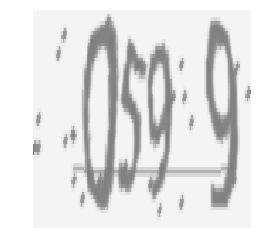

label: [0] [5] [9] [9]
predict: [0] [5] [9] [9]


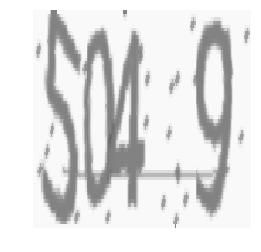

label: [5] [0] [4] [9]
predict: [5] [0] [4] [9]


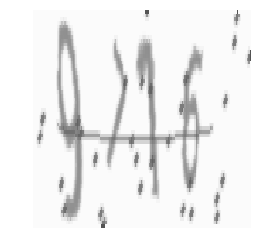

label: [9] [7] [1] [6]
predict: [9] [7] [1] [6]


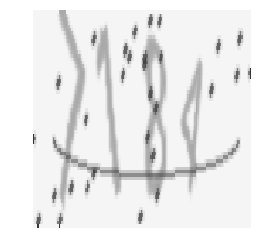

label: [7] [1] [8] [4]
predict: [7] [1] [8] [4]


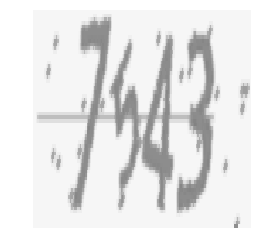

label: [7] [5] [4] [3]
predict: [7] [5] [4] [3]


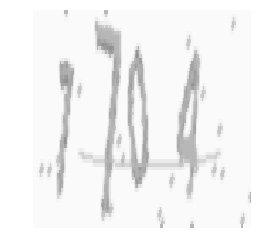

label: [1] [7] [0] [4]
predict: [1] [7] [0] [4]


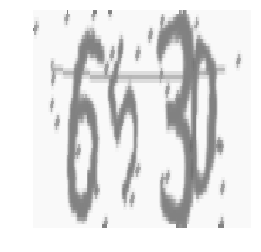

label: [6] [5] [3] [0]
predict: [6] [5] [3] [0]


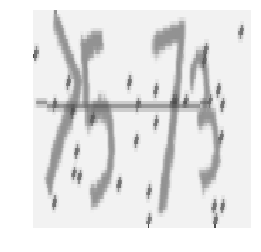

label: [7] [5] [7] [3]
predict: [7] [5] [7] [3]


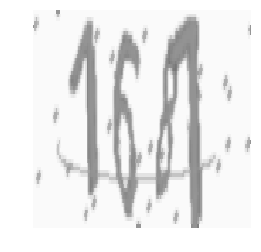

label: [1] [6] [8] [1]
predict: [1] [6] [8] [1]


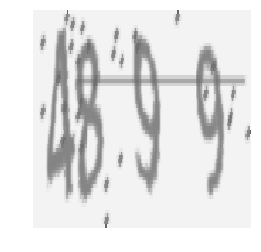

label: [4] [8] [9] [9]
predict: [4] [8] [9] [9]


In [3]:
# 获取图片数据和标签
image, image_raw, label0, label1, label2, label3 = read_and_decode(TFRECORD_FILE)

#使用shuffle_batch可以随机打乱
image_batch, image_raw_batch, label_batch0, label_batch1, label_batch2, label_batch3 = tf.train.shuffle_batch(
        [image, image_raw, label0, label1, label2, label3], batch_size = BATCH_SIZE,
        capacity = 50000, min_after_dequeue=10000, num_threads=1)

#定义网络结构
train_network_fn = nets_factory.get_network_fn(
    'alexnet_v2',
    num_classes=CHAR_SET_LEN,
    weight_decay=0.0005,
    is_training=False)

with tf.Session() as sess:
    # inputs: a tensor of size [batch_size, height, width, channels]
    X = tf.reshape(x, [BATCH_SIZE, 224, 224, 1])
    # 数据输入网络得到输出值
    logits0,logits1,logits2,logits3,end_points = train_network_fn(X)
    
    # 预测值
    predict0 = tf.reshape(logits0, [-1, CHAR_SET_LEN])  
    predict0 = tf.argmax(predict0, 1)  

    predict1 = tf.reshape(logits1, [-1, CHAR_SET_LEN])  
    predict1 = tf.argmax(predict1, 1)  

    predict2 = tf.reshape(logits2, [-1, CHAR_SET_LEN])  
    predict2 = tf.argmax(predict2, 1)  

    predict3 = tf.reshape(logits3, [-1, CHAR_SET_LEN])  
    predict3 = tf.argmax(predict3, 1)  

    # 初始化
    sess.run(tf.global_variables_initializer())
    # 载入训练好的模型
    saver = tf.train.Saver()
    saver.restore(sess,'/home/know/Documents/git/tensorflow/example-ben/model/captcha_model/crack_captcha.model-6000')

    # 创建一个协调器，管理线程
    coord = tf.train.Coordinator()
    # 启动QueueRunner, 此时文件名队列已经进队
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    for i in range(10):
        # 获取一个批次的数据和标签
        b_image, b_image_raw, b_label0, b_label1 ,b_label2 ,b_label3 = sess.run([image_batch, 
                                                                    image_raw_batch, 
                                                                    label_batch0, 
                                                                    label_batch1, 
                                                                    label_batch2, 
                                                                    label_batch3])
        # 显示图片
        img=Image.fromarray(b_image_raw[0],'L')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        # 打印标签
        print('label:',b_label0, b_label1 ,b_label2 ,b_label3)
        # 预测
        label0,label1,label2,label3 = sess.run([predict0,predict1,predict2,predict3], feed_dict={x: b_image})
        # 打印预测值
        print('predict:',label0,label1,label2,label3) 
                
    # 通知其他线程关闭
    coord.request_stop()
    # 其他所有线程关闭之后，这一函数才能返回
    coord.join(threads)